In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#Import data
train = pd.read_csv('nlp-getting-started/train.csv')
test = pd.read_csv('nlp-getting-started/test.csv')
sample_submission = pd.read_csv('nlp-getting-started/sample_submission.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(f'Train dataset has {train.shape[0]} columns and {train.shape[1]} observations')
print(f'Test dataset has {test.shape[0]} columns and {test.shape[1]} observations')

Train dataset has 7613 columns and 5 observations
Test dataset has 3263 columns and 4 observations


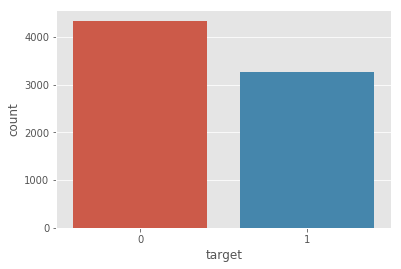

In [5]:
sns.countplot(train['target'])

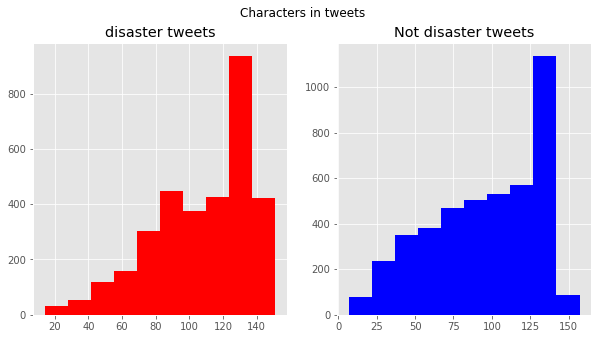

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
tweet_len = train[train['target'] == 1]['text'].str.len()
ax1.hist(tweet_len, color = 'red');
ax1.set_title('disaster tweets');
tweet_len = train[train['target'] == 0]['text'].str.len()
ax2.hist(tweet_len, color = 'blue');
ax2.set_title('Not disaster tweets');
fig.suptitle('Characters in tweets');
plt.show()

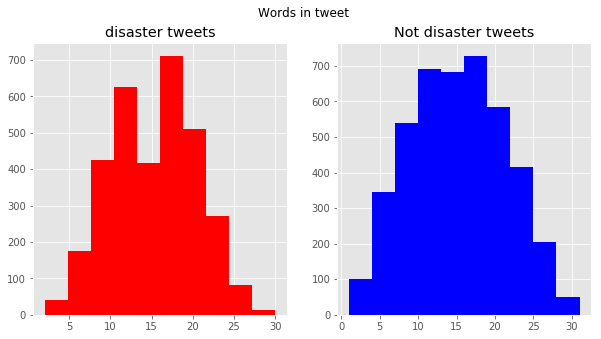

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
tweet_len = train[train['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color = 'red');
ax1.set_title('disaster tweets');
tweet_len = train[train['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color = 'blue');
ax2.set_title('Not disaster tweets');
fig.suptitle('Words in tweet')
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


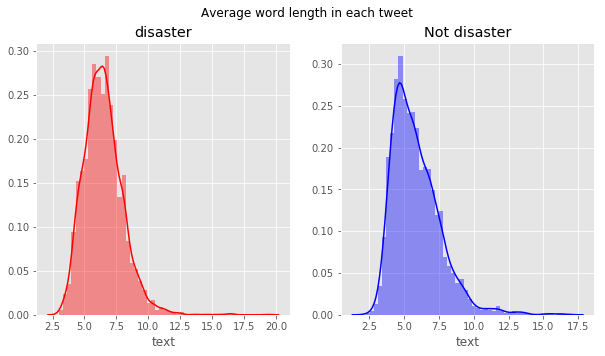

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
word = train[train['target'] == 1]['text'].str.split().map(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), color = 'red', ax = ax1);
ax1.set_title('disaster')
word = train[train['target'] == 0]['text'].str.split().map(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), color = 'blue', ax = ax2);
ax2.set_title('Not disaster');
fig.suptitle('Average word length in each tweet')
plt.show()

In [9]:
def create_corpus(target):
    corpus = []
    for word in train[train['target'] ==  target]['text'].str.split():
        for i in word:
            corpus.append(i)
    return corpus

In [10]:
corpus = create_corpus(0)

dic = defaultdict(int)
for w in corpus:
    if w in stop:
        dic[w] += 1
top = sorted(dic.items(), key = lambda x:x[1], reverse = True)[0:10]

<BarContainer object of 10 artists>

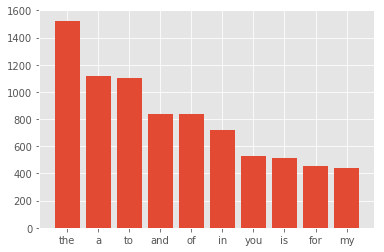

In [11]:
x, y = zip(*top)
plt.bar(x, y)

<BarContainer object of 10 artists>

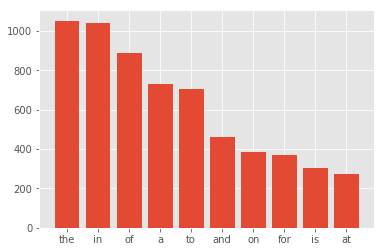

In [12]:
corpus = create_corpus(1)
dic = defaultdict(int)
for w in corpus:
    if w in stop:
        dic[w] += 1
top = sorted(dic.items(), key = lambda x:x[1], reverse=True)[0:10]
x, y = zip(*top)
plt.bar(x, y)

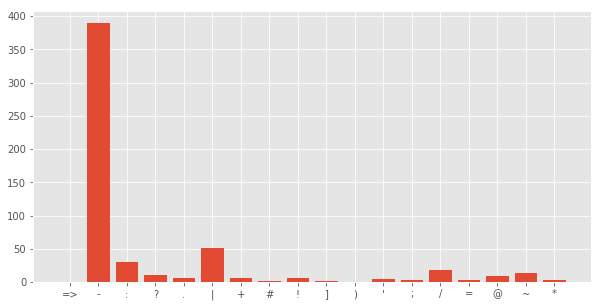

In [13]:
import string
special = string.punctuation

corpus = create_corpus(1)
dic = defaultdict(int)
for w in corpus:
    if w in special:
        dic[w]+=1
plt.figure(figsize = (10, 5))
x,y = zip(*dic.items())
plt.bar(x, y);

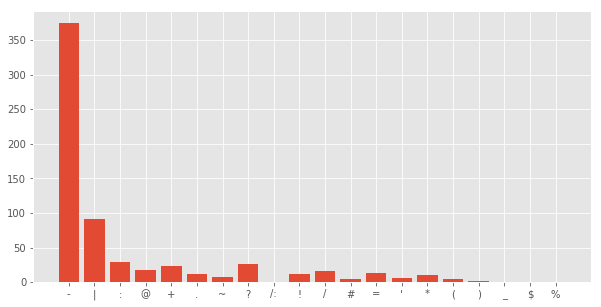

In [14]:
import string
special = string.punctuation

corpus = create_corpus(0)
dic = defaultdict(int)
for w in corpus:
    if w in special:
        dic[w]+=1
plt.figure(figsize = (10, 5))
x,y = zip(*dic.items())
plt.bar(x, y);

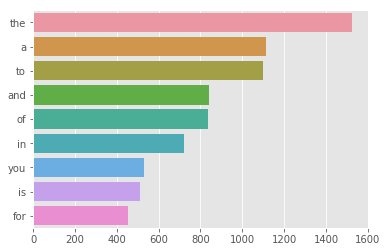

In [15]:
corpus=create_corpus(0)
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word, count in most[:10]:
    if word in stop:
        x.append(count)
        y.append(word)
sns.barplot(x, y)

In [16]:
def get_top_tweet_bigrams(corpus, n = None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x:x[1], reverse = True)
    return words_freq[:n]

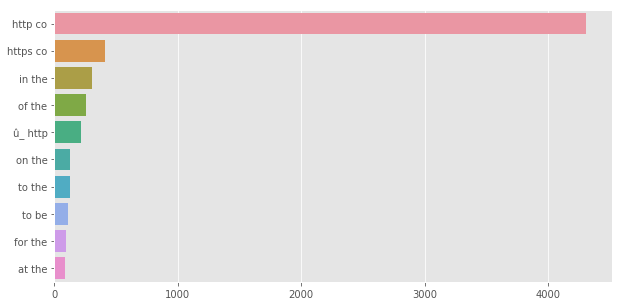

In [17]:
plt.figure(figsize = (10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(train['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x);

In [18]:
df = pd.concat([train,test])
df.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 5)

In [19]:
example = "New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [20]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
remove_URL(example)

'New competition launched :'

In [21]:
df['text'] = df['text'].apply(lambda x: remove_URL(x))

In [22]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [23]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [24]:
df['text'] = df['text'].apply(lambda x: remove_html(x))

In [25]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [26]:
df['text'] = df['text'].apply(lambda x:remove_emoji(x))

Removing punctuations

In [27]:
 def remove_punct(text):
        table = str.maketrans('','', string.punctuation)
        return text.translate(table)
example = 'I am a #king'
remove_punct(example)

'I am a king'

In [28]:
df['text'] = df['text'].apply(lambda x:remove_punct(x))

 Spelling Correction

In [29]:
!pip install pyspellchecker

In [30]:
from spellchecker import SpellChecker

In [31]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
correct_spellings('corect me plese')

'correct me please'

GloVe For Vectorization

In [32]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(
            tweet) if ((word.isalpha() == 1) & (word not in stop))]
        corpus.append(words)
    return corpus
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:03<00:00, 3101.43it/s]


In [33]:
embedding_dict = {}
with open('nlp-getting-started/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()

In [34]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

In [36]:
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')